# Violence Detection using CNN + LSTM neural netowrk

## Introduction

Today, the amount of public violence has increased dramatically. As much in high schools as in the street. This has resulted in the ubiquitous use of surveillance cameras. This has helped the authorities to identify these events and take the necessary measures. But almost all systems today require the human-inspection of these videos to identify such events, which is virtually inefficient. It is therefore necessary to have such a practical system that can automatically monitor and identify the surveillance videos.
The development of various deep learning techniques, thanks to the availability of large data sets and computational resources, has resulted in a historic change in the community of computer vision. Various techniques have been developed to address problems such as object detection, recognition, tracking, action recognition, legend generation, etc. However, despite recent developments in deep learning, very few techniques based on deep learning have been proposed to address the problem of detecting violence from videos.

## Flowchart

The method consists of extracting a set of frames belonging to the video, sending them to a pretrained network called VGG16, obtaining the output of one of its final layers and from these outputs train another network architecture with a type of special neurons called LSTM. These neurons have memory and are able to analyze the temporal information of the video, if at any time they detect violence, it will be classified as a violent video.





## Imports

In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py

In [2]:
keras.__version__

'2.11.0'

## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed the datasets

In [3]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## Load Data

Firstly, we define the directory to place the video dataset

In [4]:
in_dir = "data"

Copy some of the data-dimensions for convenience.

In [5]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 4

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

### Helper-function for getting video frames
Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural net.

In [38]:
# def get_frames(current_dir, file_name):
    
#     in_file = os.path.join(current_dir, file_name)
    
#     images = []
    
#     vidcap = cv2.VideoCapture(in_file)
    
#     success,image = vidcap.read()
        
#     count = 0

#     while count<_images_per_file:
                
#         RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#         res = cv2.resize(RGB_img, dsize=(img_size, img_size),
#                                  interpolation=cv2.INTER_CUBIC)
    
#         images.append(res)
    
#         success,image = vidcap.read()
    
#         count += 1
        
#     resul = np.array(images)
    
#     resul = (resul / 255.).astype(np.float16)
        
#     return resul

In [28]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    frames_list = []
    video_reader = cv2.VideoCapture(in_file)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    skip_frames_window = max(int(video_frames_count/_images_per_file), 1)

    for frame_counter in range(_images_per_file):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
       
        success, frame = video_reader.read()

        if not success:
            break

        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        frames_list.append(res)
    
    
    video_reader.release()
    resul = np.array(frames_list)
    
    resul = (resul / 255.).astype(np.float16)
    return resul

### Helper function to get the names of the data downloaded and label it

In [10]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'As':
                labels.append([1,0,0,0])
                names.append("Assault/"+file_name)
            elif file_name[0:2] == 'Bu':
                labels.append([0,1,0,0])
                names.append("Burglary/"+file_name)
            elif file_name[0:2] == 'No':
                labels.append([0,0,1,0])
                names.append("Normal/"+file_name)
            elif file_name[0:2] == 'Ro':
                labels.append([0,0,0,1])
                names.append("RoadAccidents/"+file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

### Plot a video frame to see if data is correct

In [11]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

Then we are going to load 20 frames of one video, for example

In [12]:
names[89]

'RoadAccidents/RoadAccidents0066.mp4'

The video has violence, look at the name of the video, starts with 'fi'

In [13]:
frames = get_frames(in_dir, names[89])

241
0  
12  
24  
36  
48  
60  
72  
84  
96  
108  
120  
132  
144  
156  
168  
180  
192  
204  
216  
228  


Convert back the frames to uint8 pixel format to plot the frame

In [14]:
visible_frame = (frames*255).astype('uint8')
len(visible_frame)

20

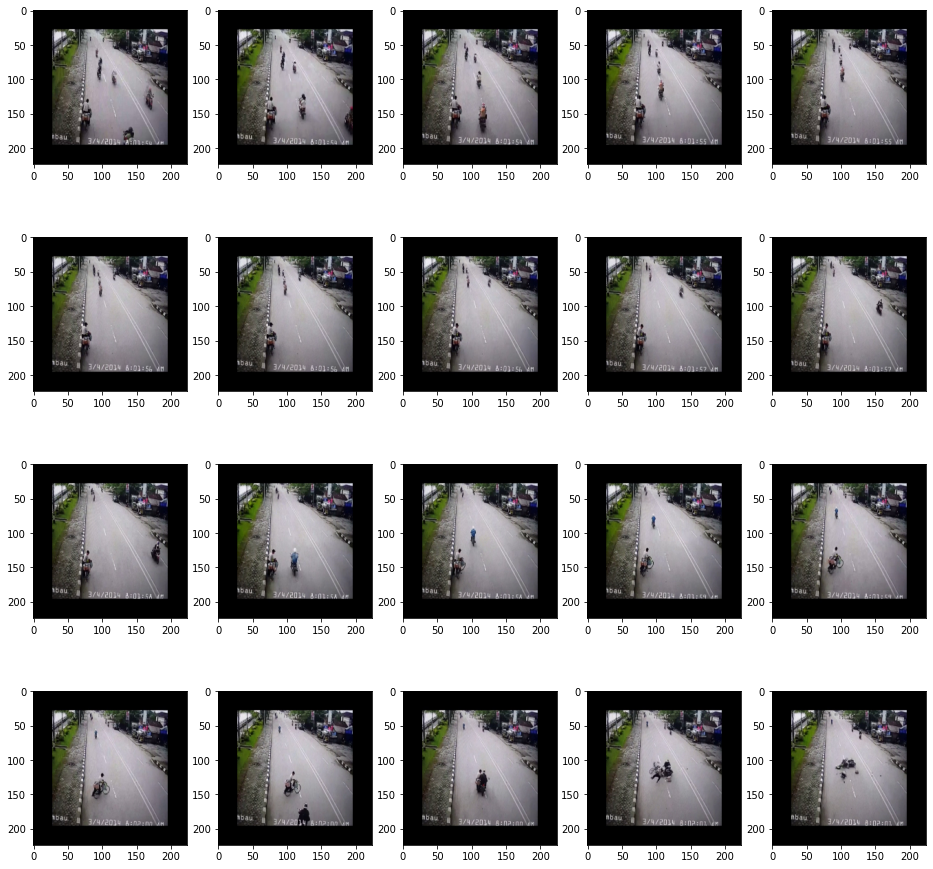

In [15]:
from matplotlib.pyplot import imshow
fig = plt.figure(figsize=(16,16))

for i,rand_indx in enumerate(visible_frame):
    ax = plt.subplot(4,5,i+1)
    # ax.set_title(class_map[predicted[i]])
   
    plt.imshow(rand_indx)




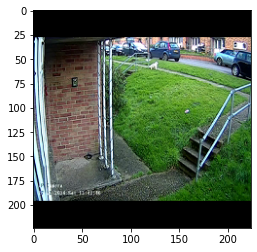

In [14]:
plt.imshow(visible_frame[15])

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

In [18]:
image_model = MobileNetV2( weights='imagenet')

Let's see the model summary

In [19]:
image_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 20 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.

The reason for using a cache-file is that it takes a long time to process an image with the VGG16 model. If each image is processed more than once then we can save a lot of time by caching the transfer-values.

When all the videos have been processed through the VGG16 model and the resulting transfer-values saved to a cache file, then we can use those transfer-values as the input to LSTM neural network. We will then train the second neural network using the classes from the violence dataset (Violence, No-Violence), so the network learns how to classify images based on the transfer-values from the VGG16 model.

In [20]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = image_model.get_layer('global_average_pooling2d_1')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  1280


### Function to process 20 video frames through VGG16 and get transfer values

In [21]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

### Generator that process one video through VGG16 each function call

In [22]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,4])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [23]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [24]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [25]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [26]:
print(names_test[0:4])
print(labels_test[0:4])

('RoadAccidents/RoadAccidents0081.mp4', 'Normal/Normal_Videos_597_x264.mp4', 'RoadAccidents/RoadAccidents003_x264.mp4', 'Normal/Normal_Videos_885_x264.mp4')
([0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0])


Then we are going to process all video frames through VGG16 and save the transfer values.

In [29]:
make_files(training_set)

1/1 [==============================] - 1s 1s/step
- Progress: 99.6%

In [30]:
make_files_test(test_set)

1/1 [==============================] - 1s 790ms/step


### Load the cached transfer values into memory
We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net. 


In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [31]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [32]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [33]:
data, target = process_alldata_training()

In [34]:
data_test, target_test = process_alldata_test()

##Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which we will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which we will use in this tutorial.

A recurrent neuron has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.



### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 20 frames so we will have 20 x 4096 values per video. The classification must be done taking into account the 20 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 20. The second is the size of the features vector (transfer values).


In [35]:
chunk_size = 1280
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

## Model training


In [36]:
epoch = 200
batchS = 500

history = model.fit(np.array(data[0:720]), np.array(target[0:720]), epochs=epoch,
                    validation_data=(np.array(data[720:]), np.array(target[720:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/200
1/1 - 22s - loss: 0.2013 - accuracy: 0.2246 - 22s/epoch - 22s/step
Epoch 2/200
1/1 - 2s - loss: 0.1719 - accuracy: 0.3544 - 2s/epoch - 2s/step
Epoch 3/200
1/1 - 1s - loss: 0.1713 - accuracy: 0.3123 - 1s/epoch - 1s/step
Epoch 4/200
1/1 - 1s - loss: 0.1477 - accuracy: 0.5614 - 1s/epoch - 1s/step
Epoch 5/200
1/1 - 2s - loss: 0.1525 - accuracy: 0.4842 - 2s/epoch - 2s/step
Epoch 6/200
1/1 - 1s - loss: 0.1169 - accuracy: 0.6596 - 1s/epoch - 1s/step
Epoch 7/200
1/1 - 1s - loss: 0.1113 - accuracy: 0.7228 - 1s/epoch - 1s/step
Epoch 8/200
1/1 - 1s - loss: 0.0991 - accuracy: 0.7404 - 1s/epoch - 1s/step
Epoch 9/200
1/1 - 1s - loss: 0.0850 - accuracy: 0.7509 - 1s/epoch - 1s/step
Epoch 10/200
1/1 - 1s - loss: 0.0801 - accuracy: 0.7509 - 1s/epoch - 1s/step
Epoch 11/200
1/1 - 1s - loss: 0.0662 - accuracy: 0.8175 - 1s/epoch - 1s/step
Epoch 12/200
1/1 - 1s - loss: 0.0616 - accuracy: 0.8386 - 1s/epoch - 1s/step
Epoch 13/200
1/1 - 2s - loss: 0.0510 - accuracy: 0.8842 - 2s/epoch - 2s/step
Epoch

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [37]:
result = model.evaluate(np.array(data_test), np.array(target_test))

3/3 [==============================] - 2s 137ms/step - loss: 0.1005 - accuracy: 0.7746


## Print the model accuracy

In [38]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.1004805937409401
accuracy 0.7746478915214539


KeyError: 'val_accuracy'

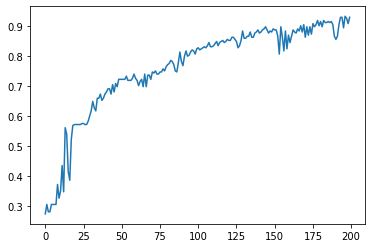

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [39]:
model.save("mob1_4p.h5")


In [3]:
from tensorflow.keras.models import load_model
new_model = load_model("t1_4.h5")

In [40]:
tes = get_transfer_values("","D:\Capstone Project\Codes\Trail 5 hockey//roadacc (1).mp4")

1/1 [==============================] - 2s 2s/step


In [41]:
model.predict(np.array([tes]))

1/1 [==============================] - 2s 2s/step


array([[0.00520937, 0.0043053 , 0.9826151 , 0.0078701 ]], dtype=float32)

In [42]:
target_test[1]

array([0., 0., 1., 0.])

In [43]:
pred = model.predict(np.array(data_test))

3/3 [==============================] - 0s 107ms/step


In [45]:
la_te = []
pr_te = []
for i in range(len(data_test)):

    la_te.append(np.argmax(target_test[i]))
    pr_te.append(np.argmax(pred[i]))

Text(0.5, 1.0, 'Confusion Matrix')

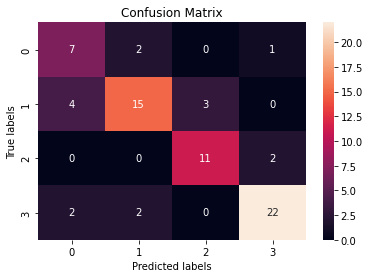

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(la_te, pr_te)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

TypeError: Invalid shape (4096,) for image data

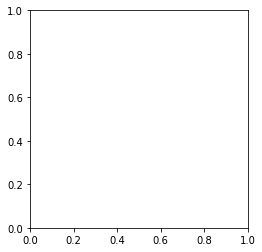

In [117]:
visible_frame = (data[0][15]*255).astype('uint8')
plt.imshow(visible_frame)

TypeError: Invalid shape (4096,) for image data

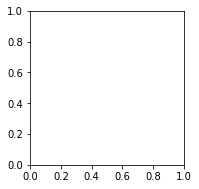

In [114]:
from matplotlib.pyplot import imshow
fig = plt.figure(figsize=(16,16))

for i,rand_indx in enumerate(data[0]):
    ax = plt.subplot(4,5,i+1)
    # ax.set_title(class_map[predicted[i]])
    visible_frame = (data[0][i]*255).astype('uint8')
    imshow(visible_frame)